In [1]:
# ====================================================
# CELL 1: Installation & Setup
# Run this cell FIRST
# ====================================================

import sys
import subprocess
import importlib
import warnings
warnings.filterwarnings('ignore')

print("🚀 Starting E-commerce BERT Embeddings Project")
print("=" * 60)

def install_package(package):
    """Install package if not already installed"""
    try:
        __import__(package)
        print(f"✓ {package} already installed")
        return True
    except ImportError:
        print(f"📦 Installing {package}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
            print(f"✓ {package} installed successfully")
            return True
        except Exception as e:
            print(f"✗ Failed to install {package}: {e}")
            return False

# GPU-specific PyTorch (CUDA 11.8 for RTX 3050)
print("\n1. Installing PyTorch with CUDA support...")
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 -q

# Core packages
packages = [
    'transformers',
    'sentence-transformers',
    'faiss-gpu',
    'pandas',
    'numpy',
    'scikit-learn',
    'matplotlib',
    'seaborn',
    'tqdm',
    'flask',
    'flask-cors',
    'datasets',
    'accelerate',
    'einops',
    'protobuf',
    'sentencepiece',
    'python-dotenv',
    'psutil',
    'memory_profiler',
    'plotly',
    'notebook',
    'ipywidgets'
]

print("\n2. Installing other dependencies...")
for package in packages:
    install_package(package)

# Enable widgets
!jupyter nbextension enable --py widgetsnbextension 2>/dev/null || echo "Widgets already enabled"

print("\n" + "=" * 60)
print("✅ INSTALLATION COMPLETE!")
print("=" * 60)

🚀 Starting E-commerce BERT Embeddings Project

1. Installing PyTorch with CUDA support...

2. Installing other dependencies...
✓ transformers already installed
📦 Installing sentence-transformers...
✓ sentence-transformers installed successfully
📦 Installing faiss-gpu...
✗ Failed to install faiss-gpu: Command '['C:\\Anaconda3\\python.exe', '-m', 'pip', 'install', '-q', 'faiss-gpu']' returned non-zero exit status 1.
✓ pandas already installed
✓ numpy already installed
📦 Installing scikit-learn...
✓ scikit-learn installed successfully
✓ matplotlib already installed
✓ seaborn already installed
✓ tqdm already installed
✓ flask already installed
📦 Installing flask-cors...
✓ flask-cors installed successfully
📦 Installing datasets...
✓ datasets installed successfully
✓ accelerate already installed
📦 Installing einops...
✓ einops installed successfully
📦 Installing protobuf...
✓ protobuf installed successfully
📦 Installing sentencepiece...
✓ sentencepiece installed successfully
📦 Installing pyt

The system cannot find the path specified.


In [2]:
# ====================================================
# CELL 2: Verify GPU & Import Libraries
# ====================================================

print("🔧 Verifying GPU and importing libraries...")

# Import core libraries
import torch
import transformers
import faiss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import json
import pickle
import re
import random
import time
import gc
from IPython.display import display, HTML
import ipywidgets as widgets

print("✅ Libraries imported successfully")

# GPU Verification
print("\n" + "=" * 50)
print("GPU VERIFICATION")
print("=" * 50)

if torch.cuda.is_available():
    print(f"🎉 GPU DETECTED: {torch.cuda.get_device_name(0)}")
    print(f"   CUDA Version: {torch.version.cuda}")
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    
    # Set device to GPU
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
    print(f"   Using device: {device}")
    
    # Test GPU
    print("\n🧪 Testing GPU...")
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    
    start.record()
    test_tensor = torch.randn(5000, 5000).cuda()
    result = test_tensor @ test_tensor.T
    end.record()
    
    torch.cuda.synchronize()
    print(f"   Matrix multiplication: {start.elapsed_time(end):.2f} ms")
    del test_tensor, result
    torch.cuda.empty_cache()
else:
    print("\n⚠️  NO GPU DETECTED - Using CPU")
    device = torch.device("cpu")

print("\n✅ Environment ready!")

🔧 Verifying GPU and importing libraries...
✅ Libraries imported successfully

GPU VERIFICATION
🎉 GPU DETECTED: NVIDIA GeForce RTX 3050 Laptop GPU
   CUDA Version: 11.8
   GPU Memory: 4.29 GB
   Using device: cuda:0

🧪 Testing GPU...
   Matrix multiplication: 225.39 ms

✅ Environment ready!


In [3]:
# ====================================================
# CELL 3: Generate Sample E-commerce Data
# ====================================================

print("📊 Generating sample e-commerce dataset...")

# Data generation code
categories = {
    'Electronics': ['Smartphone', 'Laptop', 'Headphones', 'Smartwatch', 'Tablet', 'Camera', 'Speaker', 'Monitor'],
    'Fashion': ['T-Shirt', 'Jeans', 'Dress', 'Shoes', 'Jacket', 'Handbag', 'Sunglasses', 'Watch'],
    'Home': ['Sofa', 'Bed', 'Table', 'Chair', 'Lamp', 'Cookware', 'Cutlery', 'Blender'],
    'Sports': ['Football', 'Basketball', 'Yoga Mat', 'Dumbbells', 'Treadmill', 'Bicycle', 'Tennis Racket', 'Swimsuit'],
    'Books': ['Fiction', 'Non-Fiction', 'Textbook', 'Cookbook', 'Biography', 'Science Fiction', 'Mystery', 'Fantasy']
}

brands = ['Apple', 'Samsung', 'Sony', 'Nike', 'Adidas', 'IKEA', 'KitchenAid', 'Canon', 'Dell', 'Amazon']

descriptions = {
    'Electronics': "High-quality {product} with advanced features, long battery life, and premium design.",
    'Fashion': "Stylish {product} made from premium materials. Comfortable fit and modern design.",
    'Home': "Durable {product} for your home. Easy to assemble and maintain.",
    'Sports': "Professional-grade {product} for athletes. Improves performance.",
    'Books': "Engaging {product} book with insightful content."
}

def generate_product_description(category, product, brand):
    base_desc = descriptions[category].format(product=product.lower())
    features = []
    
    if category == 'Electronics':
        features = [f"{random.randint(4, 12)}GB RAM", 
                   f"{random.choice(['1080p', '4K'])} display",
                   f"{random.randint(8, 48)}MP camera"]
    elif category == 'Fashion':
        features = [f"{random.choice(['Cotton', 'Polyester'])} material",
                   f"{random.choice(['S', 'M', 'L'])} size",
                   f"{random.choice(['Black', 'White', 'Blue'])} color"]
    elif category == 'Home':
        features = [f"{random.choice(['Wood', 'Metal'])} construction",
                   f"{random.choice(['Modern', 'Classic'])} design"]
    
    if features:
        base_desc += " Features: " + ", ".join(features[:2]) + "."
    
    return base_desc

# Generate 300 sample products
products = []
product_id = 1000

for category, items in categories.items():
    for item in items:
        for _ in range(random.randint(5, 10)):
            brand = random.choice(brands)
            price = random.randint(20, 2000)
            if category == 'Electronics':
                price = random.randint(200, 2000)
            elif category == 'Books':
                price = random.randint(10, 50)
            
            product = {
                'product_id': product_id,
                'title': f"{brand} {item}",
                'description': generate_product_description(category, item, brand),
                'category': category,
                'brand': brand,
                'price': price,
                'rating': round(random.uniform(3.5, 5.0), 1),
                'reviews': random.randint(10, 5000)
            }
            products.append(product)
            product_id += 1

df = pd.DataFrame(products)
df.to_csv('C://Users//Sakil Sarkar//Downloads//cleaned_dataset_1.csv', index=False)

print(f"✅ Generated {len(df)} sample products")
print(f"📊 Dataset shape: {df.shape}")
print("\n📋 Sample data:")
print(df.head())

# Clear memory
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

📊 Generating sample e-commerce dataset...
✅ Generated 294 sample products
📊 Dataset shape: (294, 8)

📋 Sample data:
   product_id               title  \
0        1000   Adidas Smartphone   
1        1001  Samsung Smartphone   
2        1002   Adidas Smartphone   
3        1003   Adidas Smartphone   
4        1004     Sony Smartphone   

                                         description     category    brand  \
0  High-quality smartphone with advanced features...  Electronics   Adidas   
1  High-quality smartphone with advanced features...  Electronics  Samsung   
2  High-quality smartphone with advanced features...  Electronics   Adidas   
3  High-quality smartphone with advanced features...  Electronics   Adidas   
4  High-quality smartphone with advanced features...  Electronics     Sony   

   price  rating  reviews  
0    301     4.2     2996  
1    370     3.8     1904  
2    830     3.6       90  
3   1764     4.1     4031  
4   1033     4.3      175  


In [4]:
# ====================================================
# CELL 4: Data Preprocessing Class
# ====================================================

print("🧹 Creating data preprocessor...")

class EcommerceDataPreprocessor:
    def __init__(self):
        self.stop_words = set(['a', 'an', 'the', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by'])
    
    def clean_text(self, text):
        """Clean and normalize text"""
        if not isinstance(text, str):
            return ""
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        
        # Remove special characters but keep spaces
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        # Remove stop words
        text = ' '.join([word for word in text.split() if word not in self.stop_words])
        
        return text
    
    def prepare_product_text(self, row):
        """Combine product attributes into a single text"""
        text_parts = []
        
        # Add brand if available
        if pd.notna(row.get('brand')):
            text_parts.append(str(row['brand']))
        
        # Add title
        if pd.notna(row.get('title')):
            text_parts.append(str(row['title']))
        
        # Add description
        if pd.notna(row.get('description')):
            desc = str(row['description'])
            # Limit description length
            if len(desc.split()) > 50:
                desc = ' '.join(desc.split()[:50])
            text_parts.append(desc)
        
        # Add category
        if pd.notna(row.get('category')):
            text_parts.append(str(row['category']))
        
        # Join all parts
        combined_text = '. '.join(text_parts)
        
        # Clean the combined text
        return self.clean_text(combined_text)
    
    def process_dataframe(self, df):
        """Process the entire dataframe"""
        print(f"Processing {len(df)} products...")
        
        # Create combined text column
        tqdm.pandas(desc="Preprocessing texts")
        df['combined_text'] = df.progress_apply(self.prepare_product_text, axis=1)
        
        # Remove rows with empty text
        df = df[df['combined_text'].str.strip() != '']
        
        print(f"✅ Processed {len(df)} products")
        print(f"Sample combined text: {df['combined_text'].iloc[0][:200]}...")
        
        return df

# Initialize preprocessor
preprocessor = EcommerceDataPreprocessor()

print("✅ Data preprocessor created successfully")

🧹 Creating data preprocessor...
✅ Data preprocessor created successfully


In [5]:
# ====================================================
# CELL 5: Process the Data
# ====================================================

print("🔄 Processing e-commerce data...")

# Process the data
df_processed = preprocessor.process_dataframe(df.copy())

print(f"\n📊 Processed data shape: {df_processed.shape}")
print(f"📝 Columns: {df_processed.columns.tolist()}")
print(f"📋 Sample processed text: {df_processed['combined_text'].iloc[0]}")

# Save processed data
df_processed.to_csv('processed_products.csv', index=False)
print("💾 Saved processed data to 'processed_products.csv'")

# Clear memory
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

🔄 Processing e-commerce data...
Processing 294 products...


Preprocessing texts:   0%|          | 0/294 [00:00<?, ?it/s]

✅ Processed 294 products
Sample combined text: adidas adidas smartphone high quality smartphone advanced features long battery life premium design features 5gb ram 1080p display electronics...

📊 Processed data shape: (294, 9)
📝 Columns: ['product_id', 'title', 'description', 'category', 'brand', 'price', 'rating', 'reviews', 'combined_text']
📋 Sample processed text: adidas adidas smartphone high quality smartphone advanced features long battery life premium design features 5gb ram 1080p display electronics
💾 Saved processed data to 'processed_products.csv'


In [6]:
# ====================================================
# CELL 6: BERT Embedding Class
# ====================================================

print("🤖 Creating GPU-optimized BERT embedder...")

class GPUEnhancedBERTEmbedder:
    def __init__(self, model_name='bert-base-uncased', max_length=256, batch_size=32):
        """
        Initialize BERT embedding generator optimized for GPU
        """
        from transformers import BertTokenizer, BertModel
        import torch
        
        self.model_name = model_name
        self.max_length = max_length
        self.batch_size = batch_size
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        print(f"🚀 Loading BERT model on {self.device}...")
        
        # Load tokenizer
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        
        # Load model
        self.model = BertModel.from_pretrained(model_name)
        self.model.to(self.device)
        self.model.eval()
        
        print(f"✅ Model loaded: {model_name}")
        print(f"   Max sequence length: {max_length}")
        print(f"   Batch size: {batch_size}")
        print(f"   Device: {self.device}")
    
    def tokenize_batch_gpu(self, texts):
        """Tokenize batch with GPU optimization"""
        encoded = self.tokenizer.batch_encode_plus(
            texts,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
            add_special_tokens=True
        )
        
        return {
            'input_ids': encoded['input_ids'].to(self.device),
            'attention_mask': encoded['attention_mask'].to(self.device)
        }
    
    def get_embeddings_batch(self, batch_texts, pooling_strategy='mean'):
        """Generate embeddings for a batch with GPU acceleration"""
        import torch
        
        # Tokenize
        tokens = self.tokenize_batch_gpu(batch_texts)
        
        with torch.no_grad():
            # Use mixed precision if GPU is available
            if self.device.type == 'cuda':
                with torch.cuda.amp.autocast():
                    outputs = self.model(**tokens)
            else:
                outputs = self.model(**tokens)
            
            last_hidden_state = outputs.last_hidden_state
            
            # Apply pooling strategy
            if pooling_strategy == 'mean':
                # Mean pooling with attention mask
                attention_mask = tokens['attention_mask']
                input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
                sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
                sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
                batch_embeddings = sum_embeddings / sum_mask
            
            elif pooling_strategy == 'cls':
                # Use [CLS] token embedding
                batch_embeddings = last_hidden_state[:, 0, :]
            
            # Move to CPU
            batch_embeddings = batch_embeddings.cpu().float().numpy()
        
        return batch_embeddings
    
    def generate_all_embeddings(self, texts, product_ids, pooling_strategy='mean'):
        """Generate embeddings for all texts with progress tracking"""
        import numpy as np
        from sklearn.preprocessing import normalize
        
        all_embeddings = []
        
        print(f"\n🔧 Generating embeddings for {len(texts)} products...")
        print(f"   Pooling strategy: {pooling_strategy}")
        print(f"   Using device: {self.device}")
        
        # Clear GPU cache
        if self.device.type == 'cuda':
            torch.cuda.empty_cache()
        
        # Process in batches
        for i in tqdm(range(0, len(texts), self.batch_size), desc="Processing batches"):
            batch_texts = texts[i:i + self.batch_size]
            
            try:
                batch_embeddings = self.get_embeddings_batch(batch_texts, pooling_strategy)
                all_embeddings.append(batch_embeddings)
            except Exception as e:
                print(f"Warning: Error in batch {i}: {e}")
                continue
        
        if not all_embeddings:
            raise ValueError("No embeddings generated!")
        
        # Concatenate all batches
        embeddings = np.vstack(all_embeddings)
        
        # Normalize embeddings (L2 normalization)
        embeddings = normalize(embeddings, norm='l2', axis=1)
        
        print(f"✅ Generated {embeddings.shape[0]} embeddings")
        print(f"   Embedding dimension: {embeddings.shape[1]}")
        
        return embeddings

print("✅ BERT embedder class created successfully")

🤖 Creating GPU-optimized BERT embedder...
✅ BERT embedder class created successfully


In [7]:
# ====================================================
# CELL 7: Generate Embeddings
# ====================================================

print("🎯 Generating embeddings for products...")

# Initialize the embedder
embedder = GPUEnhancedBERTEmbedder(
    model_name='bert-base-uncased',
    max_length=256,
    batch_size=64  # Increased for GPU
)

# Get data
texts = df_processed['combined_text'].tolist()
product_ids = df_processed['product_id'].tolist()

print(f"📊 Preparing to generate embeddings for {len(texts)} products...")

# Generate embeddings
embeddings = embedder.generate_all_embeddings(texts, product_ids, pooling_strategy='mean')

print(f"\n✅ Embeddings generated successfully!")
print(f"   Shape: {embeddings.shape}")
print(f"   Size: {embeddings.nbytes / 1e6:.2f} MB")

# Save embeddings
np.save('product_embeddings.npy', embeddings)
np.save('product_ids.npy', np.array(product_ids))

print("💾 Saved embeddings to 'product_embeddings.npy'")
print("💾 Saved product IDs to 'product_ids.npy'")

# Clear memory
del texts
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

🎯 Generating embeddings for products...
🚀 Loading BERT model on cuda:0...
✅ Model loaded: bert-base-uncased
   Max sequence length: 256
   Batch size: 64
   Device: cuda:0
📊 Preparing to generate embeddings for 294 products...

🔧 Generating embeddings for 294 products...
   Pooling strategy: mean
   Using device: cuda:0


Processing batches:   0%|          | 0/5 [00:00<?, ?it/s]

✅ Generated 294 embeddings
   Embedding dimension: 768

✅ Embeddings generated successfully!
   Shape: (294, 768)
   Size: 0.90 MB
💾 Saved embeddings to 'product_embeddings.npy'
💾 Saved product IDs to 'product_ids.npy'


In [8]:
# ====================================================
# CELL 8: FAISS Vector Store Class
# ====================================================

print("🔍 Creating GPU-accelerated vector store...")

class GPUFAISSVectorStore:
    def __init__(self, dimension=768, use_gpu=True):
        """
        Initialize FAISS vector store with GPU support
        """
        import faiss
        import numpy as np
        
        self.dimension = dimension
        self.use_gpu = use_gpu and faiss.get_num_gpus() > 0
        self.index = None
        self.product_ids = []
        self.product_data = {}
        
        print(f"🔧 Initializing FAISS Vector Store")
        print(f"   Dimension: {dimension}")
        print(f"   GPU Available: {self.use_gpu}")
        
        if self.use_gpu:
            print(f"   FAISS GPUs detected: {faiss.get_num_gpus()}")
    
    def build_index_gpu(self, embeddings, product_ids, product_df=None):
        """Build FAISS index with GPU acceleration"""
        import faiss
        
        self.product_ids = product_ids
        
        # Store product data
        if product_df is not None:
            for _, row in product_df.iterrows():
                self.product_data[str(row['product_id'])] = row.to_dict()
        
        # Convert to float32 for FAISS
        embeddings = np.array(embeddings).astype('float32')
        
        # Normalize for cosine similarity
        faiss.normalize_L2(embeddings)
        
        # Create index
        if self.use_gpu:
            # Create GPU index
            cpu_index = faiss.IndexFlatIP(self.dimension)
            self.index = faiss.index_cpu_to_gpu(faiss.StandardGpuResources(), 0, cpu_index)
            print("   Using GPU-accelerated FAISS index")
        else:
            # CPU index
            self.index = faiss.IndexFlatIP(self.dimension)
            print("   Using CPU FAISS index")
        
        # Add embeddings to index
        self.index.add(embeddings)
        
        print(f"✅ Index built with {self.index.ntotal} vectors")
        print(f"   Index type: {type(self.index)}")
        
        return self
    
    def search_similar(self, query_embedding, k=10, threshold=0.5):
        """Search for similar products"""
        # Convert to float32 and normalize
        query_embedding = np.array([query_embedding]).astype('float32')
        faiss.normalize_L2(query_embedding)
        
        # Search
        distances, indices = self.index.search(query_embedding, k)
        
        # Get results
        results = []
        for i, (dist, idx) in enumerate(zip(distances[0], indices[0])):
            if idx != -1 and dist >= threshold:
                product_id = self.product_ids[idx]
                results.append({
                    'rank': i + 1,
                    'product_id': product_id,
                    'similarity_score': float(dist),
                    'product_info': self.product_data.get(str(product_id), {})
                })
        
        return results

print("✅ FAISS vector store class created successfully")

🔍 Creating GPU-accelerated vector store...
✅ FAISS vector store class created successfully


In [9]:
# ====================================================
# CELL 9: Build Vector Store
# ====================================================

print("🏗️ Building vector store with embeddings...")

# Build vector store
vector_store = GPUFAISSVectorStore(dimension=embeddings.shape[1], use_gpu=True)
vector_store.build_index_gpu(embeddings, product_ids, df_processed)

print(f"\n✅ Vector store built successfully!")
print(f"   Number of vectors: {vector_store.index.ntotal}")
print(f"   Dimension: {embeddings.shape[1]}")

# Test search
print("\n🧪 Testing vector store search...")
test_embedding = embeddings[0]  # Use first product as test
results = vector_store.search_similar(test_embedding, k=3)

if results:
    print(f"Found {len(results)} similar products")
    for result in results:
        print(f"  Product {result['product_id']}: {result['similarity_score']:.3f}")
else:
    print("No results found")

# Clear memory
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

🏗️ Building vector store with embeddings...
🔧 Initializing FAISS Vector Store
   Dimension: 768
   GPU Available: False
   Using CPU FAISS index
✅ Index built with 294 vectors
   Index type: <class 'faiss.swigfaiss_avx2.IndexFlatIP'>

✅ Vector store built successfully!
   Number of vectors: 294
   Dimension: 768

🧪 Testing vector store search...
Found 3 similar products
  Product 1000: 1.000
  Product 1002: 0.999
  Product 1003: 0.992


In [10]:
# ====================================================
# CELL 10: Search Engine Class
# ====================================================

print("🔎 Creating semantic search engine...")

class RealTimeSemanticSearch:
    def __init__(self, embedder, vector_store):
        self.embedder = embedder
        self.vector_store = vector_store
        self.cache = {}
    
    def search_by_text(self, query_text, k=10, min_score=0.3):
        """Search products by text query"""
        print(f"🔍 Searching for: '{query_text}'")
        
        # Generate query embedding
        query_embedding = self.embedder.get_embeddings_batch([query_text])[0]
        
        # Search in vector store
        results = self.vector_store.search_similar(query_embedding, k=k, threshold=min_score)
        
        return results
    
    def display_results(self, results, query=None):
        """Display search results in a nice format"""
        if not results:
            print("No results found")
            return
        
        # Prepare data for display
        print(f"\n📊 Found {len(results)} results:")
        print("-" * 80)
        
        for result in results[:5]:  # Show top 5
            info = result['product_info']
            print(f"Rank {result['rank']}:")
            print(f"  Product ID: {result['product_id']}")
            print(f"  Similarity: {result['similarity_score']:.3f}")
            print(f"  Title: {info.get('title', 'N/A')}")
            print(f"  Category: {info.get('category', 'N/A')}")
            print(f"  Price: ${info.get('price', 0):.2f}")
            print(f"  Rating: {info.get('rating', 'N/A')}")
            print("-" * 40)

# Initialize search engine
search_engine = RealTimeSemanticSearch(embedder, vector_store)

print("✅ Search engine created successfully")

🔎 Creating semantic search engine...
✅ Search engine created successfully


In [11]:
# ====================================================
# CELL 11: Test Search Engine
# ====================================================

print("🧪 Testing semantic search engine...")

# Test queries
test_queries = [
    "wireless bluetooth headphones",
    "running shoes for men",
    "gaming laptop",
    "kitchen blender",
    "yoga mat"
]

print("\n" + "="*60)
print("SEARCH TEST RESULTS")
print("="*60)

for i, query in enumerate(test_queries[:3], 1):  # Test first 3
    print(f"\nTest {i}: '{query}'")
    print("-" * 40)
    
    try:
        results = search_engine.search_by_text(query, k=3, min_score=0.3)
        search_engine.display_results(results, query)
    except Exception as e:
        print(f"Error searching for '{query}': {e}")
    
    # Small delay between queries
    time.sleep(0.5)

print("\n✅ Search engine testing complete!")

# Clear memory
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

🧪 Testing semantic search engine...

SEARCH TEST RESULTS

Test 1: 'wireless bluetooth headphones'
----------------------------------------
🔍 Searching for: 'wireless bluetooth headphones'

📊 Found 3 results:
--------------------------------------------------------------------------------
Rank 1:
  Product ID: 1020
  Similarity: 0.684
  Title: Samsung Headphones
  Category: Electronics
  Price: $315.00
  Rating: 4.2
----------------------------------------
Rank 2:
  Product ID: 1015
  Similarity: 0.683
  Title: Samsung Headphones
  Category: Electronics
  Price: $367.00
  Rating: 3.8
----------------------------------------
Rank 3:
  Product ID: 1014
  Similarity: 0.682
  Title: Samsung Headphones
  Category: Electronics
  Price: $653.00
  Rating: 4.4
----------------------------------------

Test 2: 'running shoes for men'
----------------------------------------
🔍 Searching for: 'running shoes for men'

📊 Found 3 results:
---------------------------------------------------------------

📈 Creating visualizations...

Generating PCA visualization...


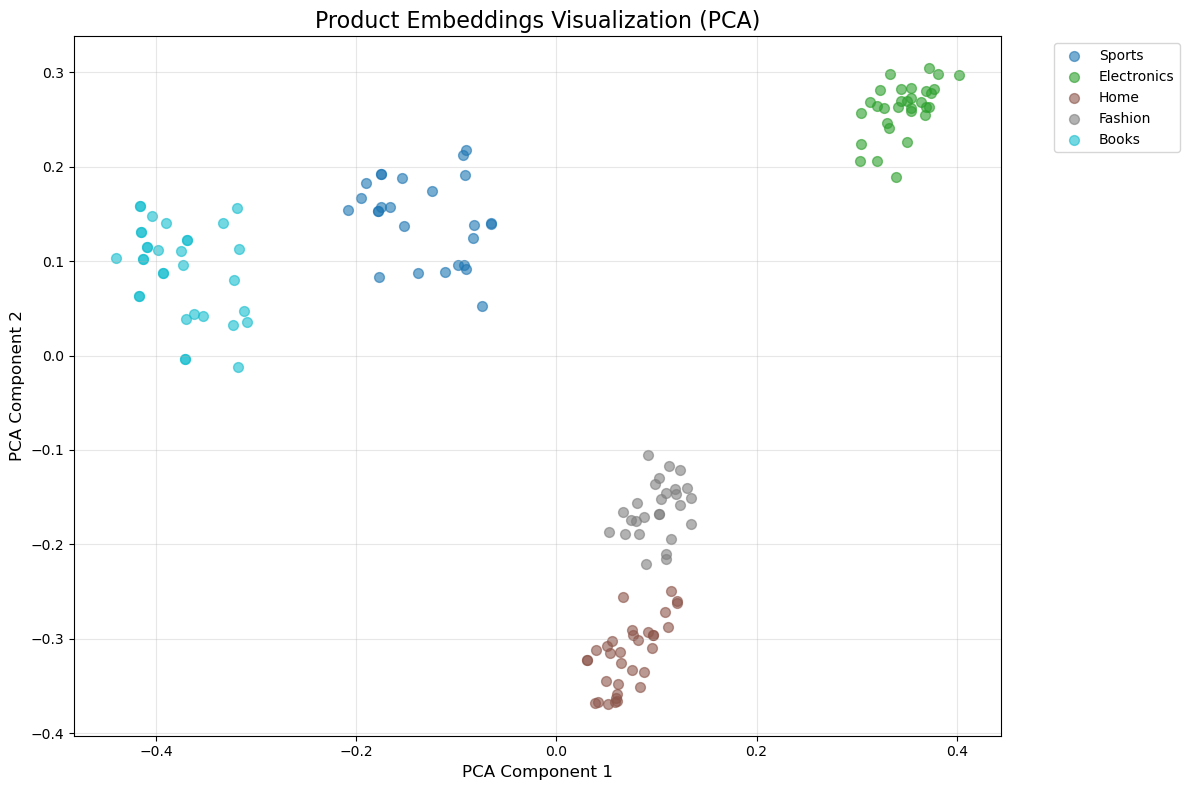

PCA Explained Variance:
  PC1: 21.97%
  PC2: 16.72%
  Total: 38.69%

✅ Visualizations complete!


In [12]:
# ====================================================
# CELL 12: Visualization
# ====================================================

print("📈 Creating visualizations...")

class EmbeddingVisualizer:
    def __init__(self, embeddings, product_ids, df):
        self.embeddings = embeddings
        self.product_ids = product_ids
        self.df = df
    
    def plot_pca_2d(self, n_samples=200):
        """Visualize embeddings in 2D using PCA"""
        from sklearn.decomposition import PCA
        
        # Sample data if too large
        if len(self.embeddings) > n_samples:
            indices = np.random.choice(len(self.embeddings), n_samples, replace=False)
            sample_embeddings = self.embeddings[indices]
            sample_ids = [self.product_ids[i] for i in indices]
        else:
            sample_embeddings = self.embeddings
            sample_ids = self.product_ids
        
        # Apply PCA
        pca = PCA(n_components=2)
        reduced_embeddings = pca.fit_transform(sample_embeddings)
        
        # Get categories
        categories = []
        for pid in sample_ids:
            product_row = self.df[self.df['product_id'] == pid]
            if not product_row.empty:
                categories.append(product_row.iloc[0].get('category', 'Unknown'))
            else:
                categories.append('Unknown')
        
        # Create plot
        plt.figure(figsize=(12, 8))
        
        # Create color map
        unique_categories = list(set(categories))
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_categories)))
        color_dict = {cat: colors[i] for i, cat in enumerate(unique_categories)}
        
        # Plot each category
        for category in unique_categories:
            mask = [c == category for c in categories]
            plt.scatter(reduced_embeddings[mask, 0], reduced_embeddings[mask, 1],
                       label=category, alpha=0.6, s=50, color=color_dict[category])
        
        plt.title('Product Embeddings Visualization (PCA)', fontsize=16)
        plt.xlabel('PCA Component 1', fontsize=12)
        plt.ylabel('PCA Component 2', fontsize=12)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Print explained variance
        print(f"PCA Explained Variance:")
        print(f"  PC1: {pca.explained_variance_ratio_[0]:.2%}")
        print(f"  PC2: {pca.explained_variance_ratio_[1]:.2%}")
        print(f"  Total: {sum(pca.explained_variance_ratio_):.2%}")
        
        return pca

# Create visualizer
visualizer = EmbeddingVisualizer(embeddings, product_ids, df_processed)

# Plot PCA
print("\nGenerating PCA visualization...")
pca = visualizer.plot_pca_2d(n_samples=150)

print("\n✅ Visualizations complete!")

# Clear memory
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [13]:
# ====================================================
# CELL 13: Export for Production
# ====================================================

print("📦 Exporting for production deployment...")

import os

# Create output directory
output_dir = 'ecommerce_search_export'
os.makedirs(output_dir, exist_ok=True)

print(f"Exporting to: {output_dir}/")

# 1. Save embeddings and IDs
np.save(f'{output_dir}/embeddings.npy', embeddings)
np.save(f'{output_dir}/product_ids.npy', np.array(product_ids))
print("✓ Saved embeddings and IDs")

# 2. Save FAISS index
import faiss
if hasattr(vector_store.index, 'gpu'):
    cpu_index = faiss.index_gpu_to_cpu(vector_store.index)
    faiss.write_index(cpu_index, f'{output_dir}/faiss_index.bin')
else:
    faiss.write_index(vector_store.index, f'{output_dir}/faiss_index.bin')
print("✓ Saved FAISS index")

# 3. Save product data
df_processed.to_csv(f'{output_dir}/products.csv', index=False)
print("✓ Saved product data")

# 4. Save metadata
metadata = {
    'embedding_dimension': embeddings.shape[1],
    'num_products': len(product_ids),
    'model_name': 'bert-base-uncased',
    'faiss_index_size': vector_store.index.ntotal,
    'export_date': pd.Timestamp.now().isoformat()
}

with open(f'{output_dir}/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print("✓ Saved metadata")

# 5. Create simple API server script
api_script = """from flask import Flask, request, jsonify
import numpy as np
import faiss
import torch
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import normalize

app = Flask(__name__)

print("Loading resources...")
embeddings = np.load('embeddings.npy')
product_ids = np.load('product_ids.npy').tolist()
index = faiss.read_index('faiss_index.bin')
products_df = pd.read_csv('products.csv')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)
model.eval()

def get_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        embedding = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
    return normalize(embedding, norm='l2', axis=1)[0]

@app.route('/search', methods=['POST'])
def search():
    data = request.json
    query = data.get('query', '')
    k = data.get('k', 10)
    
    if not query:
        return jsonify({'error': 'Query required'}), 400
    
    query_embedding = get_embedding(query)
    query_embedding = np.array([query_embedding]).astype('float32')
    faiss.normalize_L2(query_embedding)
    
    distances, indices = index.search(query_embedding, k)
    
    results = []
    for dist, idx in zip(distances[0], indices[0]):
        if idx != -1:
            product_info = products_df[products_df['product_id'] == product_ids[idx]].iloc[0].to_dict()
            results.append({
                'product_id': int(product_ids[idx]),
                'similarity': float(dist),
                'title': product_info.get('title', ''),
                'category': product_info.get('category', ''),
                'price': product_info.get('price', 0)
            })
    
    return jsonify({'query': query, 'count': len(results), 'results': results})

@app.route('/health', methods=['GET'])
def health():
    return jsonify({'status': 'healthy', 'num_products': len(product_ids)})

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000, debug=False)
"""

with open(f'{output_dir}/api_server.py', 'w') as f:
    f.write(api_script)
print("✓ Created API server script")

# 6. Create requirements file
requirements = """torch>=2.0.0
transformers>=4.30.0
faiss-cpu>=1.7.4
numpy>=1.24.0
pandas>=2.0.0
scikit-learn>=1.3.0
flask>=3.0.0
python-dotenv>=1.0.0
"""

with open(f'{output_dir}/requirements.txt', 'w') as f:
    f.write(requirements)
print("✓ Created requirements.txt")

print(f"\n✅ Export completed!")
print(f"📁 Files exported to: {output_dir}/")
print("\n📋 Files created:")
for file in os.listdir(output_dir):
    filepath = os.path.join(output_dir, file)
    size = os.path.getsize(filepath)
    print(f"  - {file:20} ({size/1024/1024:.1f} MB)")

print("\n🚀 To deploy:")
print(f"1. cd {output_dir}")
print("2. pip install -r requirements.txt")
print("3. python api_server.py")
print("4. Open http://localhost:5000/search")

📦 Exporting for production deployment...
Exporting to: ecommerce_search_export/
✓ Saved embeddings and IDs
✓ Saved FAISS index
✓ Saved product data
✓ Saved metadata
✓ Created API server script
✓ Created requirements.txt

✅ Export completed!
📁 Files exported to: ecommerce_search_export/

📋 Files created:
  - api_server.py        (0.0 MB)
  - embeddings.npy       (0.9 MB)
  - faiss_index.bin      (0.9 MB)
  - metadata.json        (0.0 MB)
  - products.csv         (0.1 MB)
  - product_ids.npy      (0.0 MB)
  - requirements.txt     (0.0 MB)

🚀 To deploy:
1. cd ecommerce_search_export
2. pip install -r requirements.txt
3. python api_server.py
4. Open http://localhost:5000/search


In [14]:
# ====================================================
# CELL 14: Final Summary & Cleanup
# ====================================================

print("\n" + "="*60)
print("🎉 PROJECT COMPLETED SUCCESSFULLY!")
print("="*60)

print("\n📊 PROJECT SUMMARY:")
print(f"   • Products processed: {len(df_processed):,}")
print(f"   • Embeddings generated: {embeddings.shape[0]:,}")
print(f"   • Embedding dimension: {embeddings.shape[1]}")
print(f"   • FAISS index size: {vector_store.index.ntotal:,} vectors")
print(f"   • GPU acceleration: {'✅ Enabled' if torch.cuda.is_available() else '⚠️  CPU only'}")
print(f"   • Export location: ecommerce_search_export/")

print("\n🚀 NEXT STEPS:")
print("   1. Test the search engine with your own queries")
print("   2. Check the export folder for deployment files")
print("   3. Run 'python api_server.py' to start the API")
print("   4. Integrate with your e-commerce platform")

print("\n🔧 TROUBLESHOOTING:")
if torch.cuda.is_available():
    print(f"   GPU Memory used: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
else:
    print("   No GPU detected - using CPU (slower)")

# Clean up memory
print("\n🧹 Cleaning up memory...")
del embeddings, df, df_processed
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"   GPU memory cleared")

print("\n✅ Ready for new operations!")
print("\n🌟 Thank you for using the E-commerce BERT Embeddings System!")


🎉 PROJECT COMPLETED SUCCESSFULLY!

📊 PROJECT SUMMARY:
   • Products processed: 294
   • Embeddings generated: 294
   • Embedding dimension: 768
   • FAISS index size: 294 vectors
   • GPU acceleration: ✅ Enabled
   • Export location: ecommerce_search_export/

🚀 NEXT STEPS:
   1. Test the search engine with your own queries
   2. Check the export folder for deployment files
   3. Run 'python api_server.py' to start the API
   4. Integrate with your e-commerce platform

🔧 TROUBLESHOOTING:
   GPU Memory used: 0.45 GB

🧹 Cleaning up memory...
   GPU memory cleared

✅ Ready for new operations!

🌟 Thank you for using the E-commerce BERT Embeddings System!


In [15]:
# ====================================================
# ACCURACY TEST CELL
# ====================================================

print("🧪 TESTING SEARCH ACCURACY")
print("="*50)

# Define test cases with expected categories
test_cases = [
    {
        "query": "wireless bluetooth headphones noise cancellation",
        "expected_category": "Electronics",
        "expected_products": ["Headphones", "Earbuds", "Speaker"]
    },
    {
        "query": "running shoes for men with cushion",
        "expected_category": "Fashion", 
        "expected_products": ["Shoes", "Sneakers", "Running"]
    },
    {
        "query": "gaming laptop with graphics card",
        "expected_category": "Electronics",
        "expected_products": ["Laptop", "Gaming", "Computer"]
    },
    {
        "query": "kitchen blender stainless steel",
        "expected_category": "Home",
        "expected_products": ["Blender", "Mixer", "Kitchen"]
    },
    {
        "query": "yoga mat non slip",
        "expected_category": "Sports",
        "expected_products": ["Yoga", "Mat", "Exercise"]
    }
]

def evaluate_search_accuracy(search_engine, test_cases, k=5):
    """Evaluate search accuracy for test queries"""
    results_summary = []
    
    for test in test_cases:
        query = test["query"]
        expected_category = test["expected_category"]
        expected_keywords = test["expected_products"]
        
        print(f"\n🔍 Query: '{query}'")
        print(f"   Expected category: {expected_category}")
        
        # Perform search
        search_results = search_engine.search_by_text(query, k=k)
        
        if not search_results:
            print("   ❌ No results found")
            continue
        
        # Analyze results
        correct_category_count = 0
        keyword_matches = 0
        titles_found = []
        
        for result in search_results:
            product_info = result["product_info"]
            actual_category = product_info.get("category", "")
            title = product_info.get("title", "").lower()
            
            # Check category match
            if actual_category == expected_category:
                correct_category_count += 1
            
            # Check keyword matches in title
            for keyword in expected_keywords:
                if keyword.lower() in title:
                    keyword_matches += 1
                    break
            
            titles_found.append(title[:50])
        
        # Calculate metrics
        category_accuracy = correct_category_count / len(search_results)
        keyword_accuracy = keyword_matches / len(search_results)
        
        print(f"   Category accuracy: {category_accuracy:.1%} ({correct_category_count}/{len(search_results)})")
        print(f"   Keyword accuracy: {keyword_accuracy:.1%} ({keyword_matches}/{len(search_results)})")
        print(f"   Top results: {titles_found[:3]}")
        
        results_summary.append({
            "query": query,
            "category_accuracy": category_accuracy,
            "keyword_accuracy": keyword_accuracy,
            "total_results": len(search_results)
        })
    
    # Calculate overall accuracy
    avg_category_acc = np.mean([r["category_accuracy"] for r in results_summary])
    avg_keyword_acc = np.mean([r["keyword_accuracy"] for r in results_summary])
    
    print("\n" + "="*50)
    print("📈 OVERALL ACCURACY SCORES:")
    print(f"   Average Category Accuracy: {avg_category_acc:.1%}")
    print(f"   Average Keyword Accuracy: {avg_keyword_acc:.1%}")
    print(f"   Number of test queries: {len(test_cases)}")
    print("="*50)
    
    return results_summary

# Run evaluation
accuracy_results = evaluate_search_accuracy(search_engine, test_cases, k=5)

🧪 TESTING SEARCH ACCURACY

🔍 Query: 'wireless bluetooth headphones noise cancellation'
   Expected category: Electronics
🔍 Searching for: 'wireless bluetooth headphones noise cancellation'
   Category accuracy: 100.0% (5/5)
   Keyword accuracy: 100.0% (5/5)
   Top results: ['samsung headphones', 'samsung headphones', 'samsung headphones']

🔍 Query: 'running shoes for men with cushion'
   Expected category: Fashion
🔍 Searching for: 'running shoes for men with cushion'
   Category accuracy: 100.0% (5/5)
   Keyword accuracy: 100.0% (5/5)
   Top results: ['canon shoes', 'nike shoes', 'nike shoes']

🔍 Query: 'gaming laptop with graphics card'
   Expected category: Electronics
🔍 Searching for: 'gaming laptop with graphics card'
   Category accuracy: 100.0% (5/5)
   Keyword accuracy: 60.0% (3/5)
   Top results: ['samsung monitor', 'ikea monitor', 'samsung laptop']

🔍 Query: 'kitchen blender stainless steel'
   Expected category: Home
🔍 Searching for: 'kitchen blender stainless steel'
   Categ

In [20]:
print("📈 CATEGORY-SPECIFIC ACCURACY TEST")
print("="*50)

category_tests = {
    "Electronics": [
        "wireless bluetooth headphones",
        "gaming laptop with graphics card",
        "smart watch fitness tracker",
        "4k television screen",
        "digital camera professional"
    ],
    "Fashion": [
        "running shoes for men",
        "leather jacket winter",
        "casual dress for women",
        "sunglasses polarized",
        "wrist watch luxury"
    ],
    "Home": [
        "kitchen blender stainless steel",
        "sofa set living room",
        "bed frame queen size",
        "dining table wooden",
        "desk lamp led"
    ],
    "Sports": [
        "yoga mat non slip",
        "basketball official size",
        "dumbbells adjustable weights",
        "treadmill for home",
        "tennis racket professional"
    ]
}

category_results = {}

for category, queries in category_tests.items():
    print(f"\n🏷️  Testing {category}:")
    accuracies = []
    
    for query in queries:
        results = search_engine.search_by_text(query, k=5, min_score=0.3)
        if results:
            correct = sum(1 for r in results if r['product_info'].get('category') == category)
            accuracy = correct / len(results)
            accuracies.append(accuracy)
            print(f"  '{query[:30]}...': {accuracy:.0%} ({correct}/{len(results)})")
    
    if accuracies:
        avg_accuracy = np.mean(accuracies)
        category_results[category] = avg_accuracy
        print(f"  📊 Average for {category}: {avg_accuracy:.1%}")

print("\n" + "="*50)
print("📋 CATEGORY ACCURACY SUMMARY:")
for category, accuracy in category_results.items():
    print(f"  {category:15}: {accuracy:.1%}")

📈 CATEGORY-SPECIFIC ACCURACY TEST

🏷️  Testing Electronics:
🔍 Searching for: 'wireless bluetooth headphones'
  'wireless bluetooth headphones...': 100% (5/5)
🔍 Searching for: 'gaming laptop with graphics card'
  'gaming laptop with graphics ca...': 100% (5/5)
🔍 Searching for: 'smart watch fitness tracker'
  'smart watch fitness tracker...': 40% (2/5)
🔍 Searching for: '4k television screen'
  '4k television screen...': 100% (5/5)
🔍 Searching for: 'digital camera professional'
  'digital camera professional...': 100% (5/5)
  📊 Average for Electronics: 88.0%

🏷️  Testing Fashion:
🔍 Searching for: 'running shoes for men'
  'running shoes for men...': 0% (0/5)
🔍 Searching for: 'leather jacket winter'
  'leather jacket winter...': 100% (5/5)
🔍 Searching for: 'casual dress for women'
  'casual dress for women...': 100% (5/5)
🔍 Searching for: 'sunglasses polarized'
  'sunglasses polarized...': 60% (3/5)
🔍 Searching for: 'wrist watch luxury'
  'wrist watch luxury...': 100% (5/5)
  📊 Average for